In [1]:
#Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics


In [2]:
#To remove warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#seaborn configuration
sns.set(rc={'figure.figsize':(10,5)}) 
sns.set_style('white')
sns.set_palette ("Set1")
#sns.set(rc={'figure.figsize':(11.7,8.27)})



## Load data

In [4]:
#file = "data/old/combined_dataframe.csv"
#df = pd.read_csv(file, sep = '\t')  

In [5]:
df_2019 = pd.read_csv("data/2019.csv", sep = '\t')  
df_2020 = pd.read_csv("data/2020.csv", sep = '\t')  
df_2021 = pd.read_csv("data/2021.csv", sep = '\t')  
df_2022 = pd.read_csv("data/2022.csv", sep = '\t')  

In [6]:
df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [7]:
df.to_csv('data/combined_dataframe.csv', index=False, header=True, sep ='\t' )

### Number of races 

In [8]:
print("Number rows dataframe: ")
print(len(df))

Number rows dataframe: 
82523


### Remove variables 

In [9]:
# the data was compiled, but then was not useful 
df = df.drop(['DriverNumber'], axis=1)

df = df.drop(['DriverAhead'], axis=1)
df = df.drop(['DriverBehind'], axis=1)



In [10]:
#! TODO  check if delete TimePit
df = df.drop(['TimePit'], axis=1)


### Track status

## Pit stops info 

In [11]:
df["HasPitLap"].value_counts()

0.0    79873
1.0     2630
Name: HasPitLap, dtype: int64

In [12]:
df["GoodPitStop"].value_counts()

0    81152
1     1371
Name: GoodPitStop, dtype: int64

In [13]:
df["HasPitLap"].value_counts()/df.shape[0]


0.0    0.967888
1.0    0.031870
Name: HasPitLap, dtype: float64

In [14]:
df["GoodPitStop"].value_counts()/df.shape[0]


0    0.983386
1    0.016614
Name: GoodPitStop, dtype: float64

In [15]:
#Remove HasPitLap colum
#df = df.drop(['HasPitLap'], axis=1)

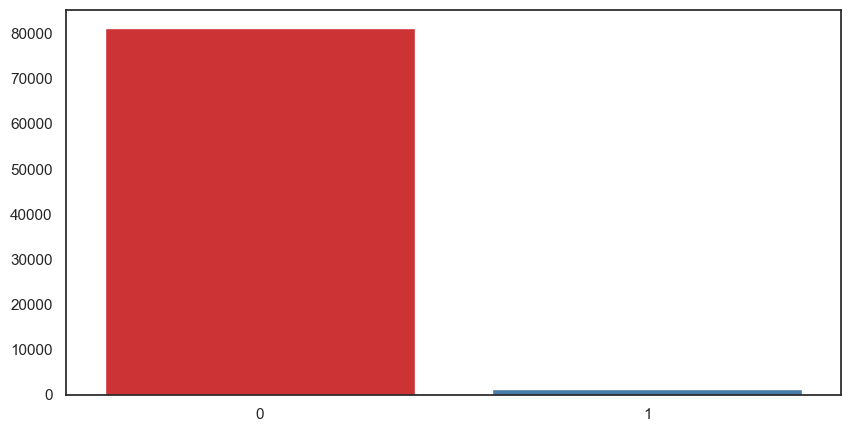

In [16]:
value_counts = df["GoodPitStop"].value_counts()

ax = sns.barplot(x=value_counts.index, y=value_counts.values)


# Data cleaning

## Rainy races
Races with rain, i.e. those in which intermediate or wet tires are used, are eliminated. 

### Plot

Text(0.5, 0, 'Years')

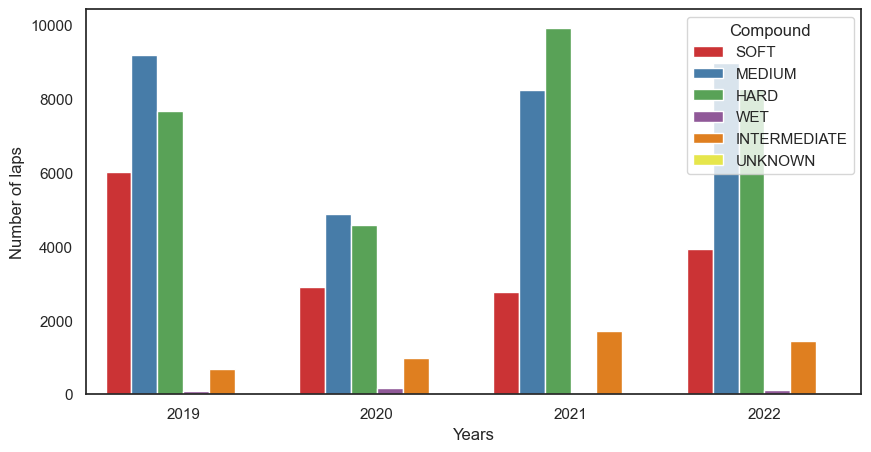

In [17]:
value_counts = df.groupby('Year')['Compound'].value_counts()
all_values = pd.MultiIndex.from_product([df['Year'].unique(), df['Compound'].unique()])
value_counts = value_counts.reindex(all_values, fill_value=0)

value_counts = value_counts.reset_index()
value_counts.columns = ['Year', 'Compound', "Value"]

# Set y-label to "number of laps"
plot = sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts)
plot.set_ylabel('Number of laps')
plot.set_xlabel('Years')

#sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts,  palette={'SOFT':'r', 'MEDIUM':'y', 'HARD':'grey','INTERMEDIATE':'g', 'WET':'b'})



### Deleted 

In [18]:
#Initialized in 1, because I have removed by hand spa in 2021 already gave an error 
initial_races = 1
rain_races= 1 
for year in df['Year'].unique():
    for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
        initial_races+=1
        val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]
        #If in that race any driver uses Intermediate or wet tyres, delete the all the sace
        if ('INTERMEDIATE' in val['Compound'].values or 'WET' in val['Compound'].values):
            rain_races +=1
            df = df.drop(val.index)

print("Total races in the DataSet: " + str(initial_races))
print("Number of races that have been eliminated due to rain: " + str(rain_races))

Total races in the DataSet: 78
Number of races that have been eliminated due to rain: 13


## Retired or more than 4 stops 


In [19]:
list_remove = pd.DataFrame()
for year in df['Year'].unique():
    for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
        for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
            if ('Finished' != val["ResultStatus"].iloc[0] and '+1 Lap' != val["ResultStatus"].iloc[0] and '+2 Lap' != val["ResultStatus"].iloc[0]):
                #print(val["ResultStatus"].iloc[0])
                list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': val["ResultStatus"].iloc[0]}, ignore_index=True)
                df = df.drop(val.index)
            elif val["NumberPitStops"].iloc[-1] >4:  
                list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': "+4 pit stops"}, ignore_index=True)
                df = df.drop(val.index)


### Plot

Text(0.5, 0, 'Reason for deleted')

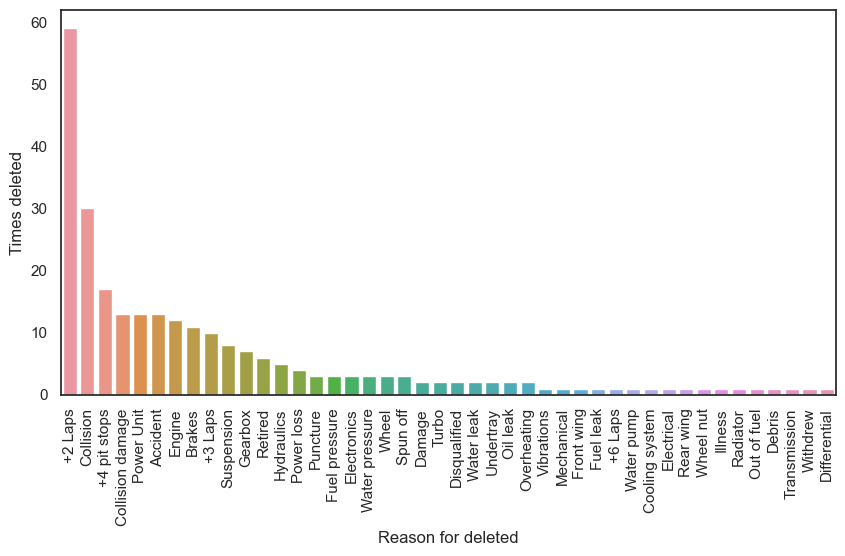

In [20]:
value_counts = list_remove["problem"].value_counts()

ax = sns.barplot(x=value_counts.index, y=value_counts.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Times deleted')
ax.set_xlabel('Reason for deleted')

### Remove colum


In [21]:
#Remove  ResultStatus colum, was useful for eliminating variables 
df = df.drop(['ResultStatus'], axis=1)

## Null values

In [22]:
null_cols = df.columns[df.isnull().any()]
print(null_cols)

Index(['QualyPosition', 'DriverStandings'], dtype='object')


### Qualy Position and GridPosition

In [23]:
for year in df['Year'].unique():
    for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
        for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
            if ( np.isnan(val["QualyPosition"].iloc[0])):
                df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "QualyPosition"] = val["Position"].iloc[0]
            if ( val["GridPosition"].iloc[0] == 0):
                df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "GridPosition"] = val["Position"].iloc[0]

### DriverStandings

In [24]:
df['DriverStandings'] = df['DriverStandings'].fillna(0)

### DriverAhead and DriverBehind

In [25]:
#TODO see if remove
#df['DriverAhead'] = df['DriverAhead'].fillna('NaN')
#df['DriverBehind'] = df['DriverBehind'].fillna('NaN')

In [26]:
df.to_csv('data/combined_dataframe_clean.csv', index=False, header=True, sep ='\t' )

## Final number laps

In [27]:
print("Number rows dataframe after preprocesing: ")
print(len(df))

Number rows dataframe after preprocesing: 
60044


In [28]:
df = df.reset_index(drop=True)  # Reset the index labels


In [29]:
df

,Year,RaceNumber,RaceName,Driver,Team,GridPosition,LapNumber,Compound,TyreLife,TyresChange,...,Position,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader,NumberPitStops,HasPitLap,DriverAheadPit,DriverBehindPit,GoodPitStop
0,2019,1,Australian Grand Prix,BOT,Mercedes,2,1,SOFT,4.0,0,...,1,00:01:33.813000,0 days 00:00:00,0 days 00:00:01.074000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
1,2019,1,Australian Grand Prix,BOT,Mercedes,2,2,SOFT,5.0,0,...,1,00:01:29.662000,0 days 00:00:00,0 days 00:00:01.171000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
2,2019,1,Australian Grand Prix,BOT,Mercedes,2,3,SOFT,6.0,0,...,1,00:01:29.246000,0 days 00:00:00,0 days 00:00:01.257000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
3,2019,1,Australian Grand Prix,BOT,Mercedes,2,4,SOFT,7.0,0,...,1,00:01:28.641000,0 days 00:00:00,0 days 00:00:01.420000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
4,2019,1,Australian Grand Prix,BOT,Mercedes,2,5,SOFT,8.0,0,...,1,00:01:28.759000,0 days 00:00:00,0 days 00:00:01.575000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60039,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,53,MEDIUM,25.0,1,...,18,00:01:32.669000,0 days 00:00:14.026000,0 days 00:00:32.494000,0 days 00:02:07.740000,1.0,0.0,1.0,1.0,0
60040,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,54,MEDIUM,26.0,1,...,18,00:01:33.057000,0 days 00:00:13.176000,0 days 00:00:35.848000,0 days 00:02:11.405000,1.0,0.0,1.0,1.0,0
60041,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,55,MEDIUM,27.0,1,...,18,00:01:32.549000,0 days 00:00:13.155000,0 days 00:01:05.367000,0 days 00:02:14.239000,1.0,0.0,1.0,1.0,0
60042,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,56,MEDIUM,28.0,1,...,17,00:01:32.782000,0 days 00:00:11.176000,0 days 00:00:00,0 days 00:02:17.177000,1.0,0.0,1.0,0.0,0


# Data Preprocessing

In [30]:
#v_categorical= ['Year', 'RaceName', 'Driver', 'Team', 'Compound', 'TrackStatus', 'DriverAhead', 'DriverBehind']

v_categorical= ['Year', 'RaceName', 'Driver', 'Team', 'Compound'] #'TrackStatus' is categorical, but make in a different way 

v_numerical = ['RaceNumber', 'GridPosition', 'LapNumber', 'TyreLife', 
               'QualyPosition', 'DriverStandings', 'Position',
               'NumberPitStops']
v_binary = ['TyresChange','DriverAheadPit', 'DriverBehindPit' ]
v_date= ['TimeLap', 'TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader'] # 'TimePit'

### Categorical 

#### Track status

In [31]:
df["TrackStatus"].value_counts()

1       53207
4        2723
2        2243
24        579
67        396
26        277
6         236
267       114
7          83
45         63
64         45
264        34
672        16
25         15
6724        6
42          6
724         1
Name: TrackStatus, dtype: int64

In [32]:
trackStatus_encoded =  pd.DataFrame()
df['TrackStatus'] = df['TrackStatus'].astype(str)
for num in range(1, 8):
    col_name = 'status_' + str(num)
    trackStatus_encoded[col_name] = df['TrackStatus'].str.contains(str(num)).astype(int)

In [33]:
trackStatus_encoded

,status_1,status_2,status_3,status_4,status_5,status_6,status_7
0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
60039,1,0,0,0,0,0,0
60040,1,0,0,0,0,0,0
60041,1,0,0,0,0,0,0
60042,1,0,0,0,0,0,0


#### The rest

In [34]:
ohe = OneHotEncoder(sparse=False)

In [35]:
categorical_encoded = pd.DataFrame(ohe.fit_transform(df[v_categorical]))

In [36]:
# Get feature names from encoder and combine with unique values
feature_names = [f"{col}_{val}" for col, vals in zip(v_categorical, v_categorical) for val in ohe.categories_[v_categorical.index(col)]]
categorical_encoded.columns = feature_names

In [37]:
#Combine with track status 
categorical_encoded = pd.concat([categorical_encoded, trackStatus_encoded], axis=1)

In [38]:
categorical_encoded

,Year_2019,Year_2020,Year_2021,Year_2022,RaceName_70th Anniversary Grand Prix,RaceName_Abu Dhabi Grand Prix,RaceName_Australian Grand Prix,RaceName_Austrian Grand Prix,RaceName_Azerbaijan Grand Prix,RaceName_Bahrain Grand Prix,...,Compound_HARD,Compound_MEDIUM,Compound_SOFT,status_1,status_2,status_3,status_4,status_5,status_6,status_7
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0,1,0,0,0,0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,0,0,0,0,0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60039,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1,0,0,0,0,0,0
60040,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1,0,0,0,0,0,0
60041,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1,0,0,0,0,0,0
60042,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1,0,0,0,0,0,0


### Binary

In [39]:
#It's already encoded, juto convert all to int 
binary_encoded = df[v_binary].astype(int)

In [40]:
binary_encoded

,TyresChange,DriverAheadPit,DriverBehindPit
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
60039,1,1,1
60040,1,1,1
60041,1,1,1
60042,1,1,0


### Numerical

In [41]:
#StandarScaler
scaler = StandardScaler()

numerical_encoded = df.groupby(['Year', 'RaceNumber'])[v_numerical].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

In [42]:
numerical_encoded

,RaceNumber,GridPosition,LapNumber,TyreLife,QualyPosition,DriverStandings,Position,NumberPitStops
0,0.0,-1.364403,-1.701887,-1.241546,-1.364403,0.000000,-1.578470,-1.410526
1,0.0,-1.364403,-1.641541,-1.150786,-1.364403,0.000000,-1.578470,-1.410526
2,0.0,-1.364403,-1.581195,-1.060026,-1.364403,0.000000,-1.578470,-1.410526
3,0.0,-1.364403,-1.520849,-0.969266,-1.364403,0.000000,-1.578470,-1.410526
4,0.0,-1.364403,-1.460503,-0.878506,-1.364403,0.000000,-1.578470,-1.410526
...,...,...,...,...,...,...,...,...
60039,0.0,1.016228,1.422559,1.393083,1.027476,0.473854,1.469650,0.119666
60040,0.0,1.016228,1.482647,1.509222,1.027476,0.473854,1.469650,0.119666
60041,0.0,1.016228,1.542735,1.625362,1.027476,0.473854,1.469650,0.119666
60042,0.0,1.016228,1.602824,1.741502,1.027476,0.473854,1.286434,0.119666


### Date

In [43]:
#Convert the times to secods 
df['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
df['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
df['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
df['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()


In [44]:
scaler = StandardScaler()

date_encoded = df.groupby(['Year', 'RaceNumber'])[v_date].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

In [45]:
date_encoded

,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader
0,1.229194,-0.740301,-0.616895,-1.376804
1,-0.075812,-0.740301,-0.607963,-1.376804
2,-0.206595,-0.740301,-0.600044,-1.376804
3,-0.396797,-0.740301,-0.585035,-1.376804
4,-0.359700,-0.740301,-0.570762,-1.376804
...,...,...,...,...
60039,0.163181,2.296950,4.485850,2.794199
60040,0.268443,2.100669,5.030943,2.911249
60041,0.130626,2.095820,9.828378,3.001758
60042,0.193837,1.638832,-0.795083,3.095589


## Combine the Dataframe

In [46]:
df_encoded = pd.concat([categorical_encoded, binary_encoded, numerical_encoded, date_encoded], axis=1)

In [47]:
df_encoded

,Year_2019,Year_2020,Year_2021,Year_2022,RaceName_70th Anniversary Grand Prix,RaceName_Abu Dhabi Grand Prix,RaceName_Australian Grand Prix,RaceName_Austrian Grand Prix,RaceName_Azerbaijan Grand Prix,RaceName_Bahrain Grand Prix,...,LapNumber,TyreLife,QualyPosition,DriverStandings,Position,NumberPitStops,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.701887,-1.241546,-1.364403,0.000000,-1.578470,-1.410526,1.229194,-0.740301,-0.616895,-1.376804
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.641541,-1.150786,-1.364403,0.000000,-1.578470,-1.410526,-0.075812,-0.740301,-0.607963,-1.376804
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.581195,-1.060026,-1.364403,0.000000,-1.578470,-1.410526,-0.206595,-0.740301,-0.600044,-1.376804
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.520849,-0.969266,-1.364403,0.000000,-1.578470,-1.410526,-0.396797,-0.740301,-0.585035,-1.376804
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.460503,-0.878506,-1.364403,0.000000,-1.578470,-1.410526,-0.359700,-0.740301,-0.570762,-1.376804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60039,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.422559,1.393083,1.027476,0.473854,1.469650,0.119666,0.163181,2.296950,4.485850,2.794199
60040,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.482647,1.509222,1.027476,0.473854,1.469650,0.119666,0.268443,2.100669,5.030943,2.911249
60041,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.542735,1.625362,1.027476,0.473854,1.469650,0.119666,0.130626,2.095820,9.828378,3.001758
60042,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.602824,1.741502,1.027476,0.473854,1.286434,0.119666,0.193837,1.638832,-0.795083,3.095589


# Classification

### Split dataframe
* Train -> 2019 2020
* Validation  -> 2021
* Test -> 2022

In [49]:
def conf_matrix_classifier_from_predictions(classifier, X, y, name = ""):
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X,
        y,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title('Confusion Matrix: ' + name)
    plt.show()

In [79]:
#TODO Add validation and and 2023
train_years= [2019, 2020, 2021]
test_years = [2022]

y_train_years_GP = df[df['Year'].isin(train_years)]['GoodPitStop']
y_test_years_GP= df[df['Year'].isin(test_years)]['GoodPitStop']
y_train_years_HP = df[df['Year'].isin(train_years)]['HasPitLap']
y_test_years_HP= df[df['Year'].isin(test_years)]['HasPitLap']
X_train_years = df_encoded.loc[y_train_years_GP.index]
X_test_years = df_encoded.loc[y_train_years_GP.index]

from sklearn.model_selection import train_test_split 
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitStop'], test_size=0.3, random_state=4815)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['HasPitLap'], test_size=0.3, random_state=4815)

### Random forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight="balanced")
print("F1 score values Random Forest:")
#Pit stop 

#Random split
rf.fit(X_train_HP, y_train_HP)
y_pred = rf.predict(X_test_HP)
print( "train_test_split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_HP,y_pred),3)))
#Year split
rf.fit(X_train_years, y_test_years_HP)
y_pred = rf.predict(X_test_years)
print( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))


#Good pit stop 
#Random split
rf.fit(X_train_HP, y_train_GP)
y_pred = rf.predict(X_test_GP)
print( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))
#Year split
rf.fit(X_train_years, y_test_years_GP)
y_pred = rf.predict(X_test_years)
print( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3)))

F1 score values Random Forest:
train_test_split for HasPitLap : 0.758


ValueError: Found input variables with inconsistent numbers of samples: [43228, 16816]

### Ramdom forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [77]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train, y_train, cv=5)

print("Cross-validation scores: {}".format(scores))
print("Mean accuracy: {:.3f}".format(scores.mean()))

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

Cross-validation scores: [0.9863193  0.98584345 0.98715203 0.98679515 0.987271  ]
Mean accuracy: 0.987


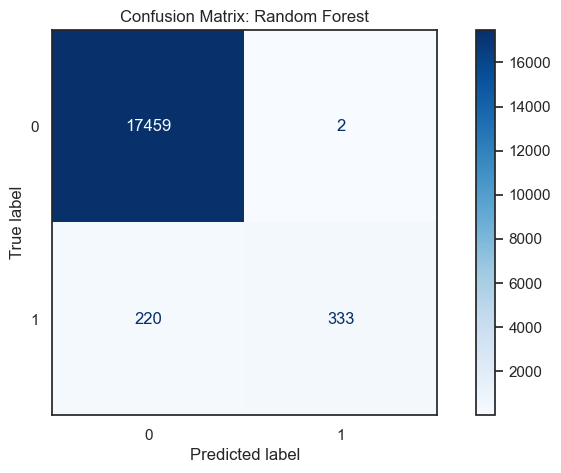

[[17459     2]
 [  220   333]]
Accuracy : 0.988
Precision : 0.994
Recall : 0.602
F1 : 0.75


In [78]:
conf_matrix_classifier_from_predictions(rf, X_test, y_test, name = 'Random Forest')

print(metrics.confusion_matrix(y_test,y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,y_pred),3)))

### SVM

In [52]:
from sklearn.svm import SVC
from sklearn import metrics

SVM_res = SVC()
SVM_res.fit(X_train, y_train)
Y_pred = SVM_res.predict(X_test)


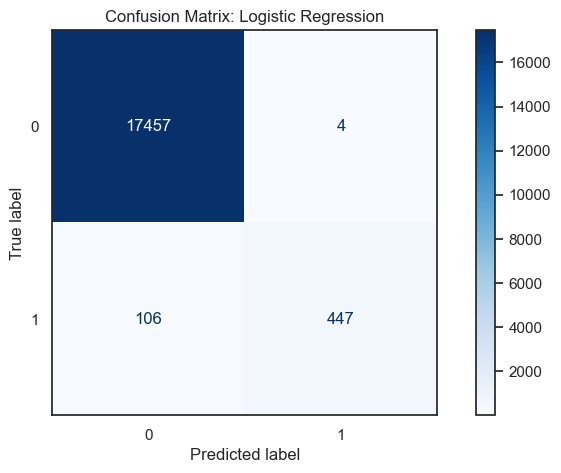

[[17457     4]
 [  106   447]]
Accuracy : 0.994
Precision : 0.991
Recall : 0.808
F1 : 0.89


In [53]:
conf_matrix_classifier_from_predictions(SVM_res, X_test, y_test, name = 'Logistic Regression')


print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))